In [1]:
import numpy as np
from numpy.random import randn, permutation, seed
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import time

In [2]:
import random
from typing import Any, Dict, List, Tuple, Union, Callable, Optional, Sequence
from itertools import product
import numba
import numpy as np
from numpy.random import permutation
from scipy.spatial.distance import pdist, squareform

In [3]:
"""
Data generators. Yield tuples of the form
(nx, ny), (params), trial, X, Y
"""
    
def generate_shifted(dims: int = 2, nsample: Tuple[int,...]=(10, 25), trials: int = 10):
    for dmu in np.linspace(0,1,21):
        for nx in nsample:     # number of samples in X
            ny = nx
            for trial in range(trials):
                seed(trial)
                mu = np.array([0, dmu])
                X = randn(dims, nx)
                Y = randn(dims, ny) + mu[:, None]
                yield ((nx, ny), (norm(mu), ), trial, X, Y)

def generate_scaled(dims: int = 2, nsample: Tuple[int,...]=(10, 25), trials: int = 10):                    
    for scale in np.linspace(0.5,2,21):
        for nx in nsample:     
            ny = nx
            for trial in range(trials):
                seed(trial)
                X = randn(dims, nx)
                Y = randn(dims, ny)*scale   
                yield ((nx, ny), (scale, ), trial, X, Y)
                        
def generate_aniso(dims: int = 2, nsample: Tuple[int,...]=(10, 25), trials: int = 10):                    
    for aniso in np.linspace(0.1,10,21):
        for nx in nsample:     
            ny = nx
            for trial in range(trials):
                seed(trial)
                X = randn(dims, nx)
                Y = randn(dims, ny)*np.array([np.sqrt(aniso), 1/np.sqrt(aniso)])[:, None]
                yield ((nx, ny), (aniso, ), trial, X, Y)
                        
def generate_rot(dims: int = 2, nsample: Tuple[int,...]=(10, 25), trials: int = 10):        
    aniso = 5
    for rot in np.linspace(0, np.pi/4, 21):
        for nx in nsample:     
            ny = nx
            for trial in range(trials):
                seed(trial)
                X = randn(dims, nx)*np.array([np.sqrt(aniso), 1/np.sqrt(aniso)])[:, None]
                Y = randn(dims, ny)*np.array([np.sqrt(aniso), 1/np.sqrt(aniso)])[:, None]
                Y = np.array([
                    [np.cos(rot), np.sin(rot)],
                    [-np.sin(rot), np.cos(rot)],
                ]) @ Y
                yield ((nx, ny), (rot*180/np.pi, ), trial, X, Y)

In [4]:
def run_tests(gen, tests, k: int = 100):
    
    results = {}
    start = True
    for nsample, param, trial, X, Y in gen:

        nx, ny = nsample
        param = tuple(param)

        if trial == 0:
            if not start:
                # calculate means and stds
                results[(nsample, param)] = {
                    'stats': [(np.mean(s), np.std(s)) for s in stats],
                    'pvals': [(np.mean(s), np.std(s)) for s in pvals],
                    'times': [(np.mean(s), np.std(s)) for s in times],
                }
            stats = [[] for _ in range(len(tests))]
            pvals = [[] for _ in range(len(tests))]
            times = [[] for _ in range(len(tests))]
            start = False

        for n, test in enumerate(tests):
            t_start = time.time()
            s, p, k = test(X.T, Y.T, k)
            t_end = time.time()
            deltat = 1000*(t_end-t_start) 
            stats[n].append(s)
            pvals[n].append(p)
            times[n].append(deltat)
            
    return results

In [5]:
from pp5.stats.two_sample import tw_test, mmd_test, kde2d_test, gaussian_kernel
from functools import partial

In [6]:
dims = 2
nsample = (25, )
ntrials = 10
niters = 100

gens = {
    'shift': generate_shifted(dims=dims, nsample=nsample, trials=ntrials),
    'scale': generate_scaled(dims=dims, nsample=nsample, trials=ntrials),
    'aniso': generate_aniso(dims=dims, nsample=nsample, trials=ntrials),
    'rotation': generate_rot(dims=dims, nsample=nsample, trials=ntrials),
}
tests = {
    'tw': tw_test,
    'mmd': mmd_test,
    'kde2d': partial(kde2d_test, n_bins=64, grid_low=-3,grid_high=3,dtype=np.float64,kernel_fn=gaussian_kernel,),
}

results = {
    param: run_tests(gen, [*tests.values()], k=niters)
    for param, gen in gens.items()
}

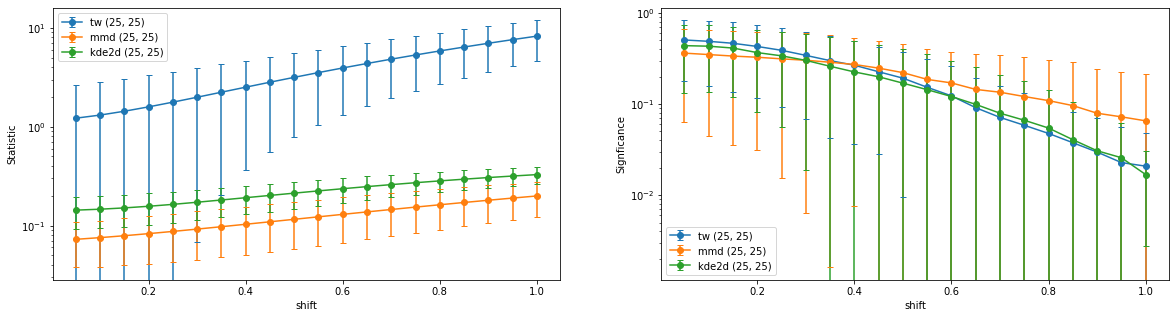

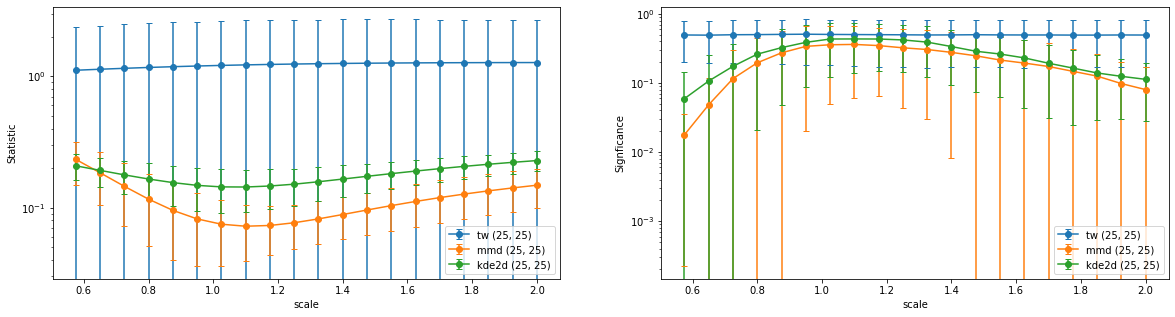

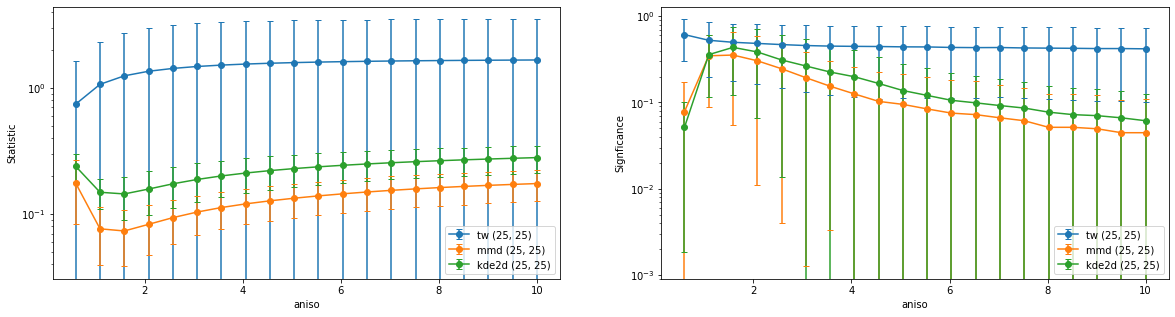

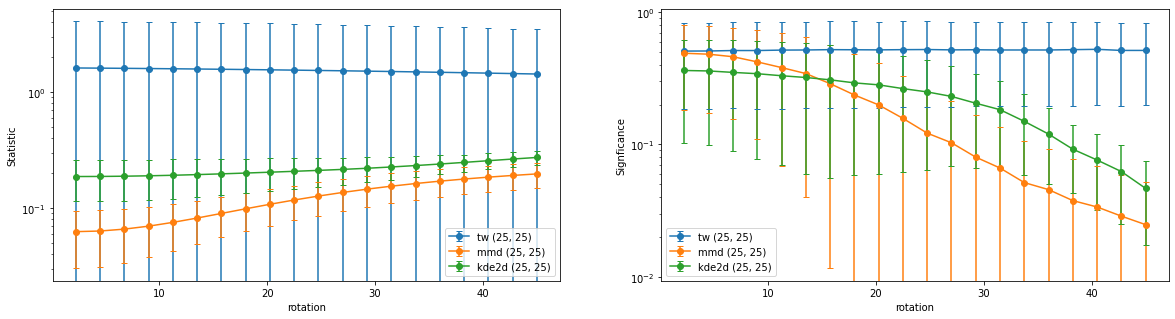

In [7]:
keys = {
    'stats': ('Statistic', 'log'), # linear
    'pvals': ('Signficance', 'log'),
}
        

for param_name in results.keys():
    result = results[param_name]

    # Select max sample sie
    ns = {ns for ns, param in result.keys()}
    ns = (sorted(ns)[-1], )
    for n in ns:
        plt.figure(figsize=(20,5))
        param = [param[0] for ns, param in result.keys() if ns == n]
        for k, (key, (label, scale)) in enumerate(keys.items()):
            mean_stat = np.array([
                [v[0] for v in val[key]]
                for (ns, param), val in result.items() if ns == n
            ])
            std_stat = np.array([
                [v[1] for v in val[key]]
                for (ns, param), val in result.items() if ns == n
            ])
            plt.subplot(1,len(keys),k+1)
            for nt, t in enumerate(tests.keys()):
                plt.errorbar(param, mean_stat[:,nt], yerr=std_stat[:,nt], capsize=3, marker='o', label=t)
            plt.legend([f"{k} {n}" for k in tests.keys()])
            plt.ylabel(label)
            plt.xlabel(param_name)
            plt.yscale(scale)
